In [2]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import capLib as ca
import fdulib as vdf
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto

In [3]:
dmHALO = vdf.Halo("/data/OWN/McMillan_HR/McMillan_dm.g2", "halo",
              dens=True,simutokms=65.69,hsml=True,center=[499.9,499.9,499.9])


In [4]:
dmdensHALO = vdf.Halo("/data/OWN/McMillan_HR/McMillan_dm_dens_03.g2",
                     "all",dens=True,simutokms=65.69,hsml=True,center=[499.9,499.9,499.9])

In [5]:
print dmdensHALO.z[np.where(dmdensHALO.rho==np.max(dmdensHALO.rho))]

[ 0.15118408]


In [6]:
size =.5
dmdensHALO.get_dens(7-size,7+size,size)
rhos7 = dmdensHALO.rho_shell 
rho7 = dmdensHALO.rho_ring

print np.mean(rho7)
dmdensHALO.get_dens(8-size,8+size,size)
rhos8 = dmdensHALO.rho_shell
rho8 = dmdensHALO.rho_ring
print np.mean(rho8)

dmdensHALO.get_dens(9-size,9+size,size)
rhos9 = dmdensHALO.rho_shell
rho9 = dmdensHALO.rho_ring
print np.mean(rho9)
print len(rho7)

4.45099e-10
3.49784e-10
2.89262e-10
6376


In [7]:
print np.min(rho7), np.max(rho7)

2.03696e-10 9.94975e-10


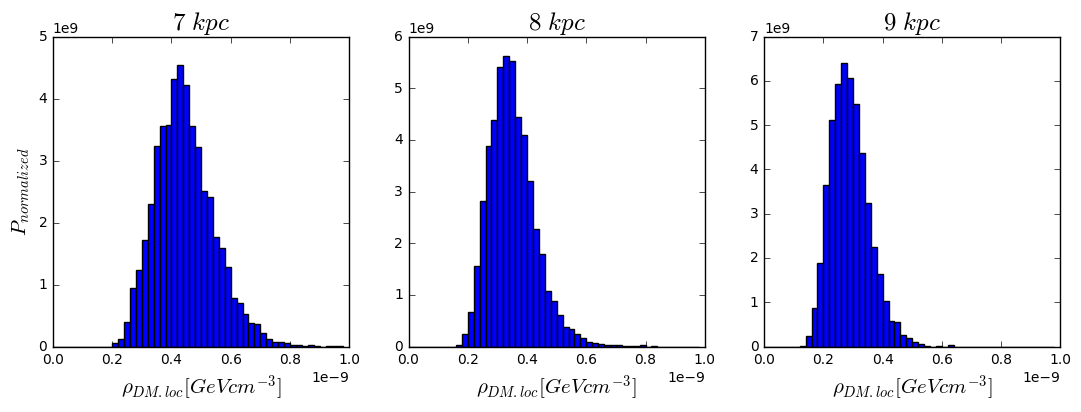

In [8]:
vertical = np.arange(0,4,0.01)
mean7 = np.array([np.mean(rho7) for i in vertical])
mean8 = np.array([np.mean(rho8) for i in vertical])
mean9 = np.array([np.mean(rho9) for i in vertical])
means7 = np.array([np.mean(rhos7) for i in vertical])
means8 = np.array([np.mean(rhos8) for i in vertical])
means9 = np.array([np.mean(rhos9) for i in vertical])
bin_size = 2e-11
rho_array = np.arange(0,np.max(rho7),bin_size)


hist7 = np.histogram(rho7,bins=rho_array, normed=True)
hist8 = np.histogram(rho8,bins=rho_array, normed=True)
hist9 = np.histogram(rho9,bins=rho_array, normed=True)

fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize = [13,4])
#ax.set_ylim([0,3])
#ax.set_xlim([0,2])
#ax1.set_ylim([0,3])
#ax1.set_xlim([0,2])
#ax2.set_ylim([0,3])
#ax2.set_xlim([0,2])
ax.set_title(r'$7\,\, kpc$', fontsize=18)
ax1.set_title(r'$8\,\, kpc$', fontsize=18)
ax2.set_title(r'$9\,\, kpc$', fontsize=18)
ax.set_ylabel(r'$P_{normalized}$',fontsize=15)
ax.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax1.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax2.set_xlabel(r'$\rho_{DM.loc}[GeV cm^{-3}]$',fontsize=15)
ax.bar(hist7[1][:-1],hist7[0],width=bin_size)
ax1.bar(hist8[1][:-1],hist8[0],width=bin_size)
ax2.bar(hist9[1][:-1],hist9[0],width=bin_size)
ax.plot(mean7,vertical,'k--')
ax1.plot(mean8,vertical,'k--')
ax2.plot(mean9,vertical,'k--')

hists7 = np.histogram(rhos7,bins=rho_array, normed=True)

hists8 = np.histogram(rhos8,bins=rho_array, normed=True)
hists9 = np.histogram(rhos9,bins=rho_array, normed=True)

fig, (ax,ax1,ax2) = plt.subplots(1,3, figsize = [13,4])
ax.set_ylabel(r'$P_{normalized}$',fontsize=15)
ax.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
ax1.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
ax2.set_xlabel(r'$\rho_{DM}[GeV cm^{-3}]$',fontsize=15)
#ax.set_ylim([0,4])
#ax.set_xlim([0,2])
#ax1.set_ylim([0,4])
#ax1.set_xlim([0,2])
#ax2.set_ylim([0,4])
#ax2.set_xlim([0,2])
ax.bar(hists7[1][:-1],hists7[0],width=bin_size)
ax1.bar(hists8[1][:-1],hists8[0],width=bin_size)

ax2.bar(hists9[1][:-1],hists9[0],width=bin_size)
ax.plot(means7,vertical,'k--')
ax1.plot(means8,vertical,'k--')
ax2.plot(means9,vertical,'k--')

In [9]:
rho = dmdensHALO.rho 
x,y,z = dmdensHALO.x, dmdensHALO.y, dmdensHALO.z
rxy , rxz, ryz = sqrt(x**2 + y**2), sqrt(x**2 + z**2), sqrt(z**2 + y**2) 

print np.min(rxy[~np.isnan(rxy)]),len(rxy),len(rxz),len(ryz)
print len(rho),len(x),len(y),len(z)

result = rho[(rxy<=8.5)&(rxy>=7.5)&(abs(z-5.)<1.)]
print np.mean(result[~np.isnan(result)])

0.00354845 16688313 16688313 16688313
16688313 16688313 16688313 16688313
2.57593e-10


In [10]:
def surdensitexy(zval):
    result = rho[(abs(rxy-8.)<1.)&(abs(z-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

def surdensitexz(zval):
    result = rho[(abs(rxz-8.)<1.)&(abs(y-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

def surdensiteyz(zval):
    result = rho[(abs(ryz-8.)<1.)&(abs(x-zval)<1.)]
    return np.mean(result[~np.isnan(result)])

get_xy = np.vectorize(surdensitexy)
get_xz = np.vectorize(surdensitexz)
get_yz = np.vectorize(surdensiteyz)

z_array = np.arange(-15,16,1.)
res = get_xy(z_array)
res2 = get_xz(z_array)
res3 = get_yz(z_array)



In [34]:
def ratio(R,plane):
    dmdensHALO.get_dens(R-.5,R+.5,0.5,plane=plane)
    ring, shell = np.mean(dmdensHALO.rho_ring), np.mean(dmdensHALO.rho_shell)

    return ring /shell
rationaicer = np.vectorize(ratio)
R_array= np.arange(0,10,0.25)
ratio_resxy = rationaicer(R_array,"x")
ratio_resyz = rationaicer(R_array,"y")    
ratio_resxz = rationaicer(R_array,"z")

In [35]:

horizontal = np.arange(-15,15,1.)
mean= np.array([np.mean(rhos8) for i in horizontal])

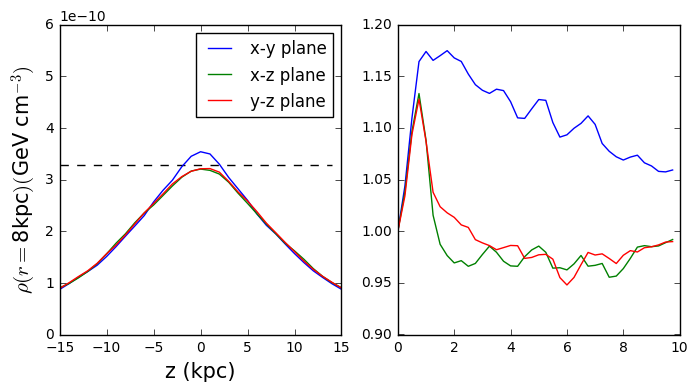

In [36]:


fig, (ax,ax1) = plt.subplots(1,2,figsize=[8,4])
#fig.tight_layout(w_pad=5.5)
ax.set_ylim([0,6e-10])
ax.set_xlabel("z (kpc)",fontsize=15)
ax.set_ylabel(r'$\rho (r=$8kpc$)($GeV cm$^{-3})$',fontsize=15)
#ax.text(6,np.mean(rhos8)+0.01,r'$\rho mean$',size=12)
ax.plot(horizontal,mean,'k--')
ax.plot(z_array,res,label = "x-y plane")
ax.plot(z_array,res2,label = "x-z plane")
ax.plot(z_array,res3,label = "y-z plane")
legend = ax.legend(loc='upper right', shadow=False)

#ax1.set_xlabel("R (kpc)",fontsize=15)
#ax1.set_ylabel(r'$\rho_{DM} ^{disc} / \rho_{DM} ^{shell} $',fontsize=15)
ax1.plot(R_array,ratio_resxy)
ax1.plot(R_array,ratio_resxz)
ax1.plot(R_array,ratio_resyz)


In [14]:

starsHALO = vdf.Halo("/data/OWN/McMillan_HR/McMillan_strs.g2", "all",
              dens=True,simutokms=65.69,hsml=True,center=[499.9,499.9,499.9])

starsHALO.get_ring_xy(7.5,8.5,.5)
print len(starsHALO.v_ringXY)

811452


In [15]:
bin_size=5.
v_str_array = np.arange(-100,100,bin_size)
v_str_phi_array = np.arange(-300,-100,bin_size)
vr_st_hist = np.histogram(starsHALO.vr_ringXY,
                          bins=v_str_array,normed=True)
vphi_st_hist = np.histogram(starsHALO.vphi_ringXY,
                          bins=v_str_phi_array,normed=True)
vz_st_hist = np.histogram(starsHALO.vz_ringXY,
                          bins=v_str_array,normed=True)

<Container object of 39 artists>

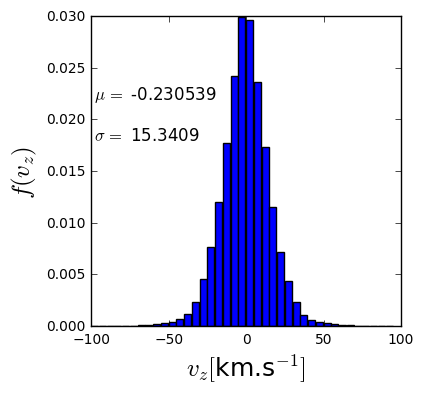

In [16]:
fig, (ax,ax1)=plt.subplots(1,2,figsize=[8,4])
fig.tight_layout(w_pad=5.5)
ax.set_xlabel(r'$v_r [$km.s$^{-1}]$',fontsize=18)
ax.set_ylabel(r'$f(v_r)$',fontsize=18)
ax.text(-90,0.02,r'$\mu\,=$ '+str(np.mean(starsHALO.vr_ringXY)),size=12)
ax.text(-90,0.018,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vr_ringXY))),
        size=12)
ax1.text(-180,0.035,r'$\mu\,=$ '+str(np.mean(starsHALO.vphi_ringXY)),size=12)
ax1.text(-180,0.03,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vphi_ringXY))),
        size=12)
ax1.set_xlabel(r'$v_{\phi} [$km.s$^{-1}]$',fontsize=18)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=18)
ax.bar(vr_st_hist[1][:-1],vr_st_hist[0],width=bin_size*9./10.)
ax1.bar(vphi_st_hist[1][:-1],vphi_st_hist[0],width=bin_size*9./10.)
fig,ax = plt.subplots(figsize=[4,4])
ax.set_xlabel(r'$v_z [$km.s$^{-1}]$',fontsize=18)
ax.set_ylabel(r'$f(v_z)$',fontsize=18)
ax.text(-98,0.022,r'$\mu\,=$ '+str(np.mean(starsHALO.vz_ringXY)),size=12)
ax.text(-98,0.018,r'$\sigma\,=$ '+str(sqrt(np.var(starsHALO.vz_ringXY))),
        size=12)
ax.bar(vz_st_hist[1][:-1],vz_st_hist[0],width=bin_size*9./10.)

In [17]:
np.random.seed(1209)
dmHALO.get_ring_xy(7.5,8.5,1.)
dmindex = np.random.randint(0,high=len(dmHALO.vR_ringXY),size=1004)
xdm = dmHALO.x_ringXY[dmindex]
ydm = dmHALO.y_ringXY[dmindex]
vxdm = dmHALO.vx_ringXY[dmindex]/120.
vydm = dmHALO.vy_ringXY[dmindex]/120.

In [18]:
np.random.seed(1234)
dmindex = np.random.randint(0,high=len(starsHALO.vR_ringXY),size=843)
dmindex =np.random.choice(len(starsHALO.vR_ringXY),1004)
xstr = starsHALO.x_ringXY[dmindex]
ystr = starsHALO.y_ringXY[dmindex]
vxstr = starsHALO.vx_ringXY[dmindex]/150.
vystr = starsHALO.vy_ringXY[dmindex]/150.

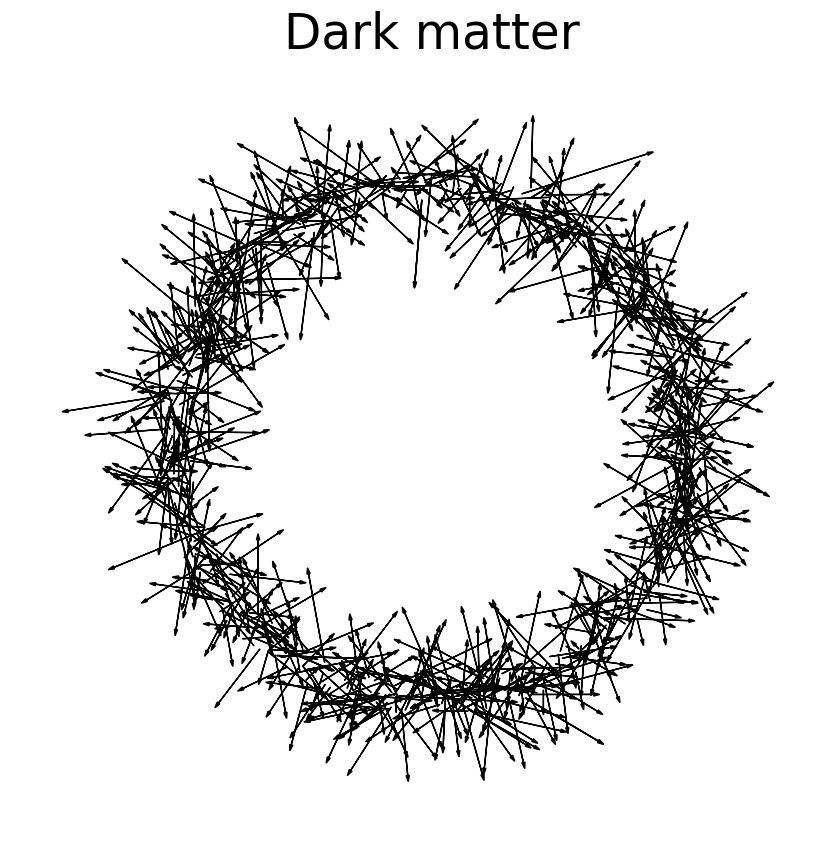

In [19]:
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])
plt.axis('off')
ax.set_title("Dark matter",fontsize=35)

for i in range(0,len(xdm)):
    ax.arrow(xdm[i], ydm[i], vxdm[i], vydm[i], head_width=0.1, head_length=.19, fc='k', ec='k')


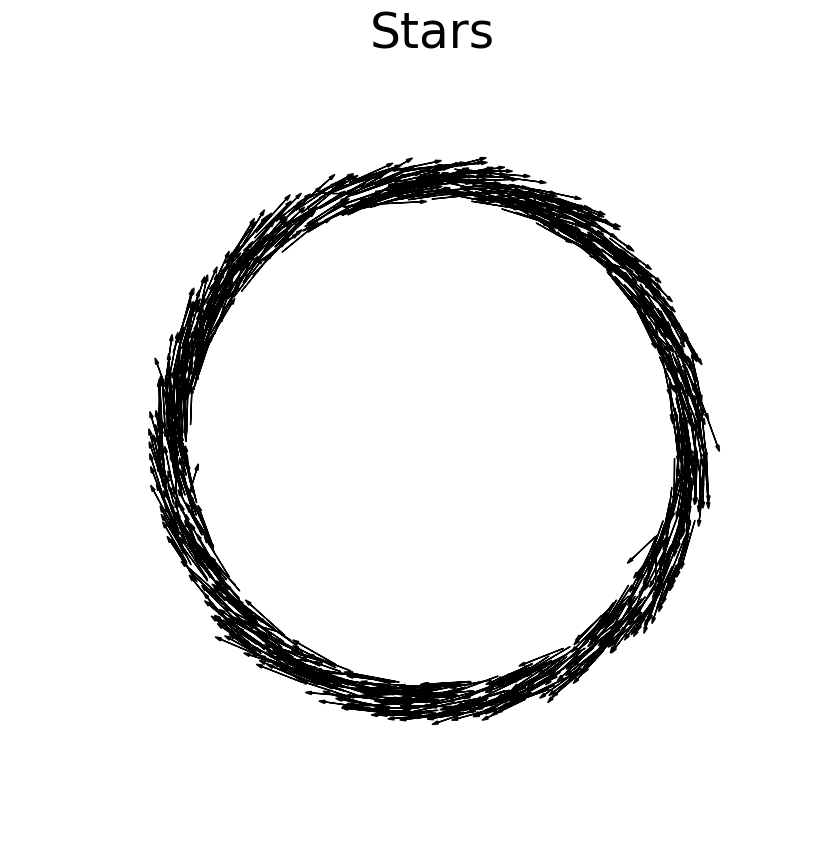

In [20]:
fig,ax = plt.subplots(figsize=[10,10])
ax.set_xlim([-12,12])
ax.set_ylim([-12,12])
plt.axis('off')
ax.set_title("Stars",fontsize=35)
for i in range(0,len(xstr)):
    ax.arrow(xstr[i],ystr[i],vxstr[i],vystr[i],
             head_width=0.1, head_length=.19, fc='k', ec='k')

In [21]:
dmHALO.get_shell(7.5,8.5)

In [22]:
#### ring hist
bin_array = np.arange(-500,500,50)
bin_array_mod = np.arange(0,550,20)
vR_Hist_ring = np.histogram(dmHALO.vR_ringXY,bins=bin_array,normed=1)
vphi_Hist_ring = np.histogram(dmHALO.vphi_ringXY,bins=bin_array,normed=1)
vz_Hist_ring = np.histogram(dmHALO.vz_ringXY,bins=bin_array,normed=1)
vmod_Hist_ring = np.histogram(dmHALO.v_ringXY,bins=bin_array_mod,normed=1)

#### shell hist
bin_array = np.arange(-600,600,20)
bin_array2 = np.arange(0,600,10)
vR_Hist_shell = np.histogram(dmHALO.vR_shell,bins=bin_array,normed=1)
vphi_Hist_shell = np.histogram(dmHALO.vphi_shell,bins=bin_array,normed=1)
vz_Hist_shell = np.histogram(dmHALO.vz_shell,bins=bin_array,normed=1)
vmod_Hist_shell = np.histogram(dmHALO.v_shell,bins=bin_array2,normed=1)

In [23]:
def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)

def myChi2(obs,exp,dof):
    return np.sum((obs-exp)**2/exp/dof,dtype=np.float64)

def myGenGaussian(x,mu,v0,alpha):
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myGenMaxwellian(x,v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def myMaxwellian(x,v0):
    alpha = 1.
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def maosDistribution(x,v0,p):
    v_esc =541.
    term = ((v_esc**2) - (x**2))**p
    if x < v_esc and x > 0: 
        return (x**2) * np.exp(-x/v0) * term
    else:
        return 0
    
    
#############################################################
#===========================================================#
##################### FITTING SECTION #######################
#===========================================================#
#############################################################


class MyGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200):
        alpha = 1.
        n = 2 * v0 *gamma(1+(1/(2*alpha)))
        return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
        
class MyDoubleGaussianModel(FunctionModel1DAuto):
    def f(self,x,frac=0.5,v01=100,mu2=.1,v02=200):
        return frac*myGaussian(x,mu2,v01)+(1-frac)*myGaussian(x,0,v02)
    

class MyGenGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200.,alpha=1.3):
        n = 2. * v0 * gamma(1.+(1./(2*alpha)))
        return (1./n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
    
class MyGenMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=300.,alpha=1.5):
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MyMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=250.):
        alpha = 1.
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MaoModel(FunctionModel1DAuto):
    def f(self,x,v0=300.,p=2.):
        v_esc =541.
        term = ((v_esc**2) - (x**2))**p
        return (x**2) * np.exp(-x/v0) * term
#        return (x**2) * np.exp(-x/v0) * term

def myChi2(obs, expected):
    return np.sum((obs-expected)**2/expected)

### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_G_fit = myG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_G_fit = myG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])

### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_ring[1][:-1],vz_Hist_ring[0])

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Mao



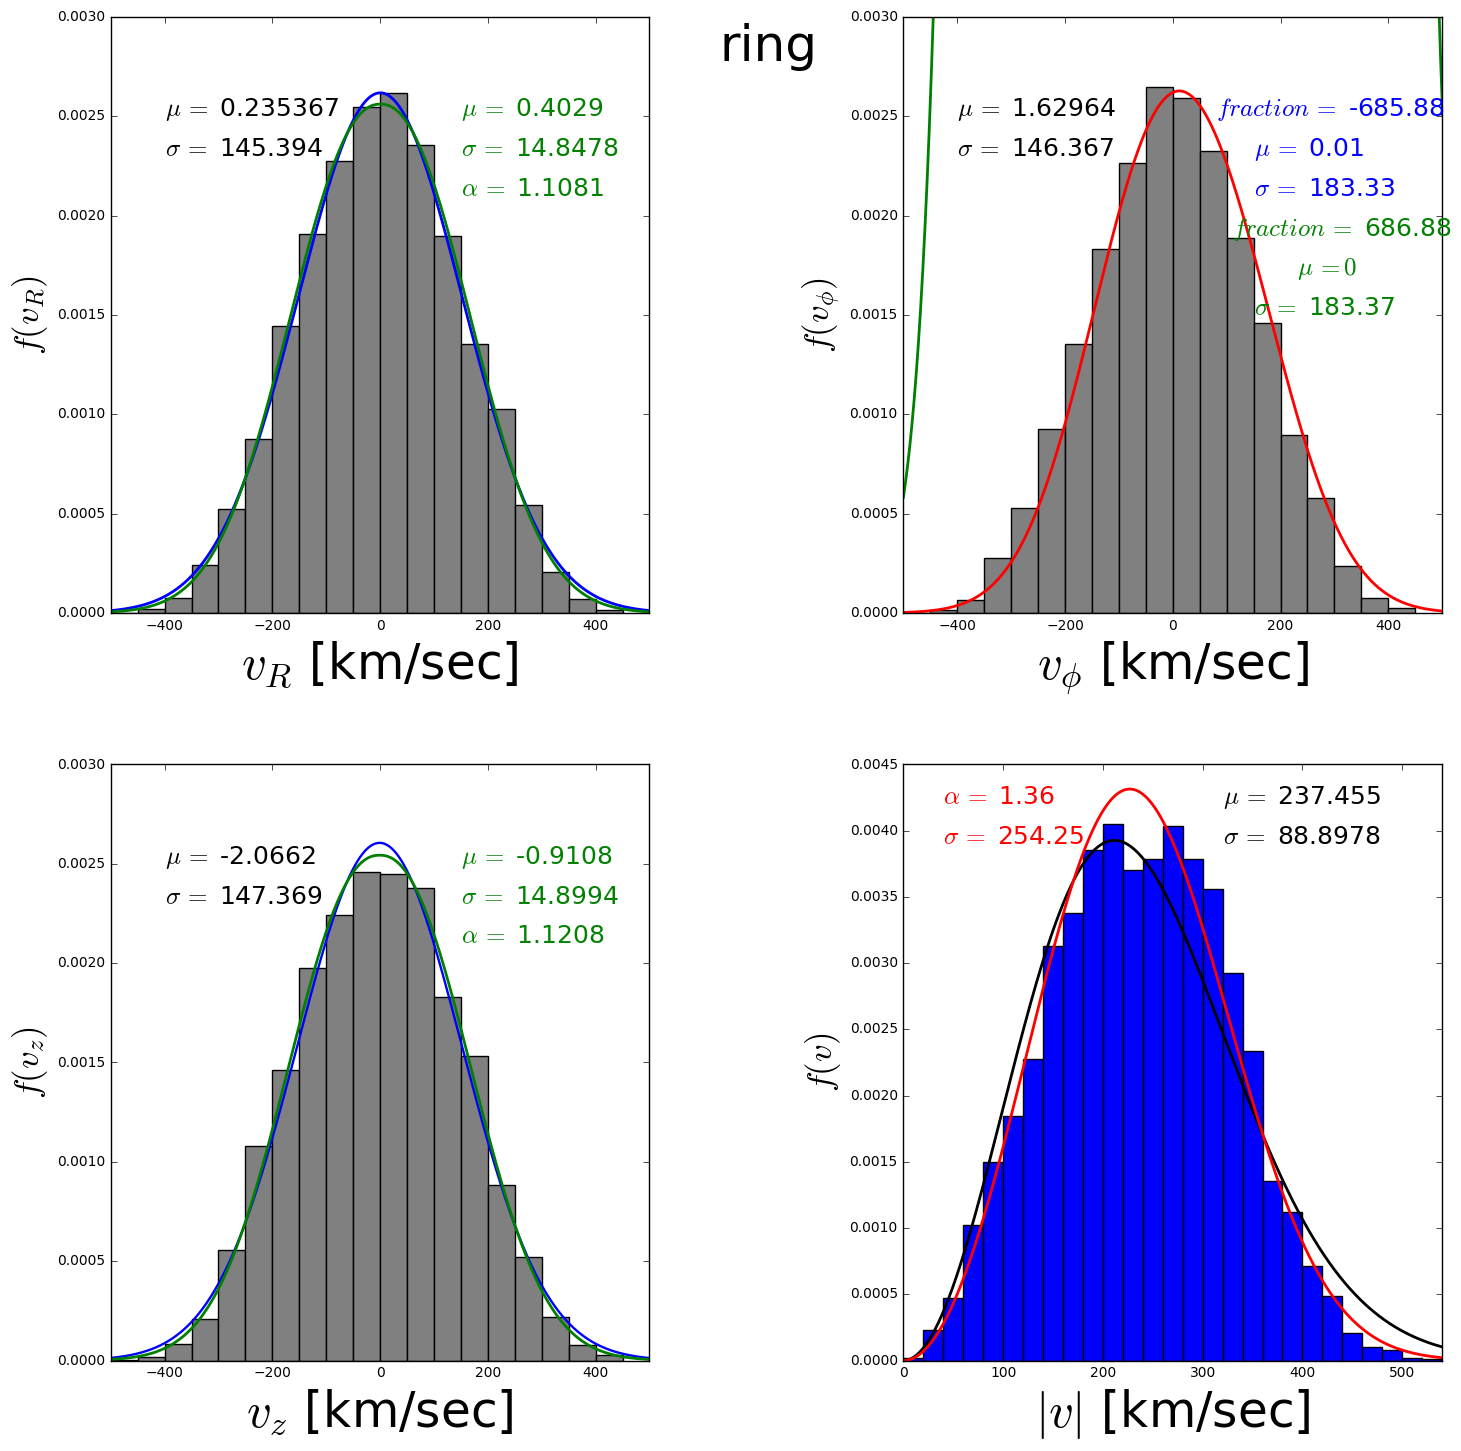

In [27]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
fig.tight_layout(h_pad=8.,w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("ring", size=36)
fig.tight_layout(w_pad=15.5, h_pad=9.0)

ax.set_xlabel(r'$v_R$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_R)$',fontsize=25)
ax.set_xlim([-500,500])
ax.set_ylim([0,0.003])
bin_array = np.arange(-500,500,50)
bin_array2 = np.arange(-500,500,10)


ax.bar(vR_Hist_ring[1][:-1],vR_Hist_ring[0], width=50, color='gray')

ax.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vR_ringXY)),size=18)
ax.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vR_ringXY))),
        size=18)

ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)
ax1.set_xlim([-500,500])
ax1.set_ylim([0,0.003])

ax1.bar(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0], width=50,
        color='gray')
ax1.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vphi_ringXY)),size=18)
ax1.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vphi_ringXY))),
        size=18)

ax2.set_xlim([-500,500])
ax2.set_ylim([0,0.003])
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)

ax3.set_xlim([0,540])
ax3.set_ylim([0,0.0045])

ax2.bar(vz_Hist_ring[1][:-1],vz_Hist_ring[0], width=50,
        color='gray')
ax2.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vz_ringXY)),size=18)
ax2.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vz_ringXY))),
        size=18)

bin_array_mod = np.arange(0,550,20)

ax3.bar(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0], width=20,
        color='blue')

ax3.text(320,0.0042,r'$\mu\,=$ '+str(np.mean(dmHALO.v_ringXY)),size=18)
ax3.text(320,0.0039,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.v_ringXY))),
        size=18)

############ plot fits
v_test = np.arange(-525,525)
ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

ax.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(R_GG_fit[0])),size=18,color="green")
ax.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(R_GG_fit[1]))),
        size=18,color="green")
ax.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(R_GG_fit[2])),
        size=18,color="green")


ax1.plot(v_test+25,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test+25, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
ax1.plot(v_test+25, myDoubleGaussianFunc(v_test,phi_DG_fit[0],
                                      phi_DG_fit[1],phi_DG_fit[2],
                                      phi_DG_fit[3]),linewidth = 2)

ax1.text(80,0.0025,r'$fraction\,=$ '+str('{0:.2f}'.format(phi_DG_fit[0])),
        size=18,color="blue")
ax1.text(150,0.0023,r'$\mu\,=$ '+str('{0:.2f}'.format((phi_DG_fit[2]))),
        size=18,color="blue")
ax1.text(150,0.0021,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[1])),
        size=18,color="blue")
ax1.text(110,0.0019,r'$fraction\,=$ '+str('{0:.2f}'.format(1-phi_DG_fit[0])),
        size=18,color="green")
ax1.text(230,0.0017,r'$\mu\,=0$ ',
        size=18,color="green")
ax1.text(150,0.0015,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[3])),
        size=18,color="green")


ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

ax2.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(z_GG_fit[0])),size=18,color="green")
ax2.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(z_GG_fit[1]))),
        size=18,color="green")
ax2.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(z_GG_fit[2])),
        size=18,color="green")

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)

ax3.text(40,0.0042,r'$\alpha\,=$ '+str('{0:.2f}'.format((v_GM_fit[1]))),
        size=18,color="red")
ax3.text(40,0.0039,r'$\sigma\,=$ '+str('{0:.2f}'.format(v_GM_fit[0])),
        size=18,color="red")

In [25]:
### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_G_fit = myG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_G_fit = myG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])


### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])
print phi_DG_fit

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Mao

[ -6.85882144e+02   1.83332765e+02   1.03732920e-02   1.83372539e+02]


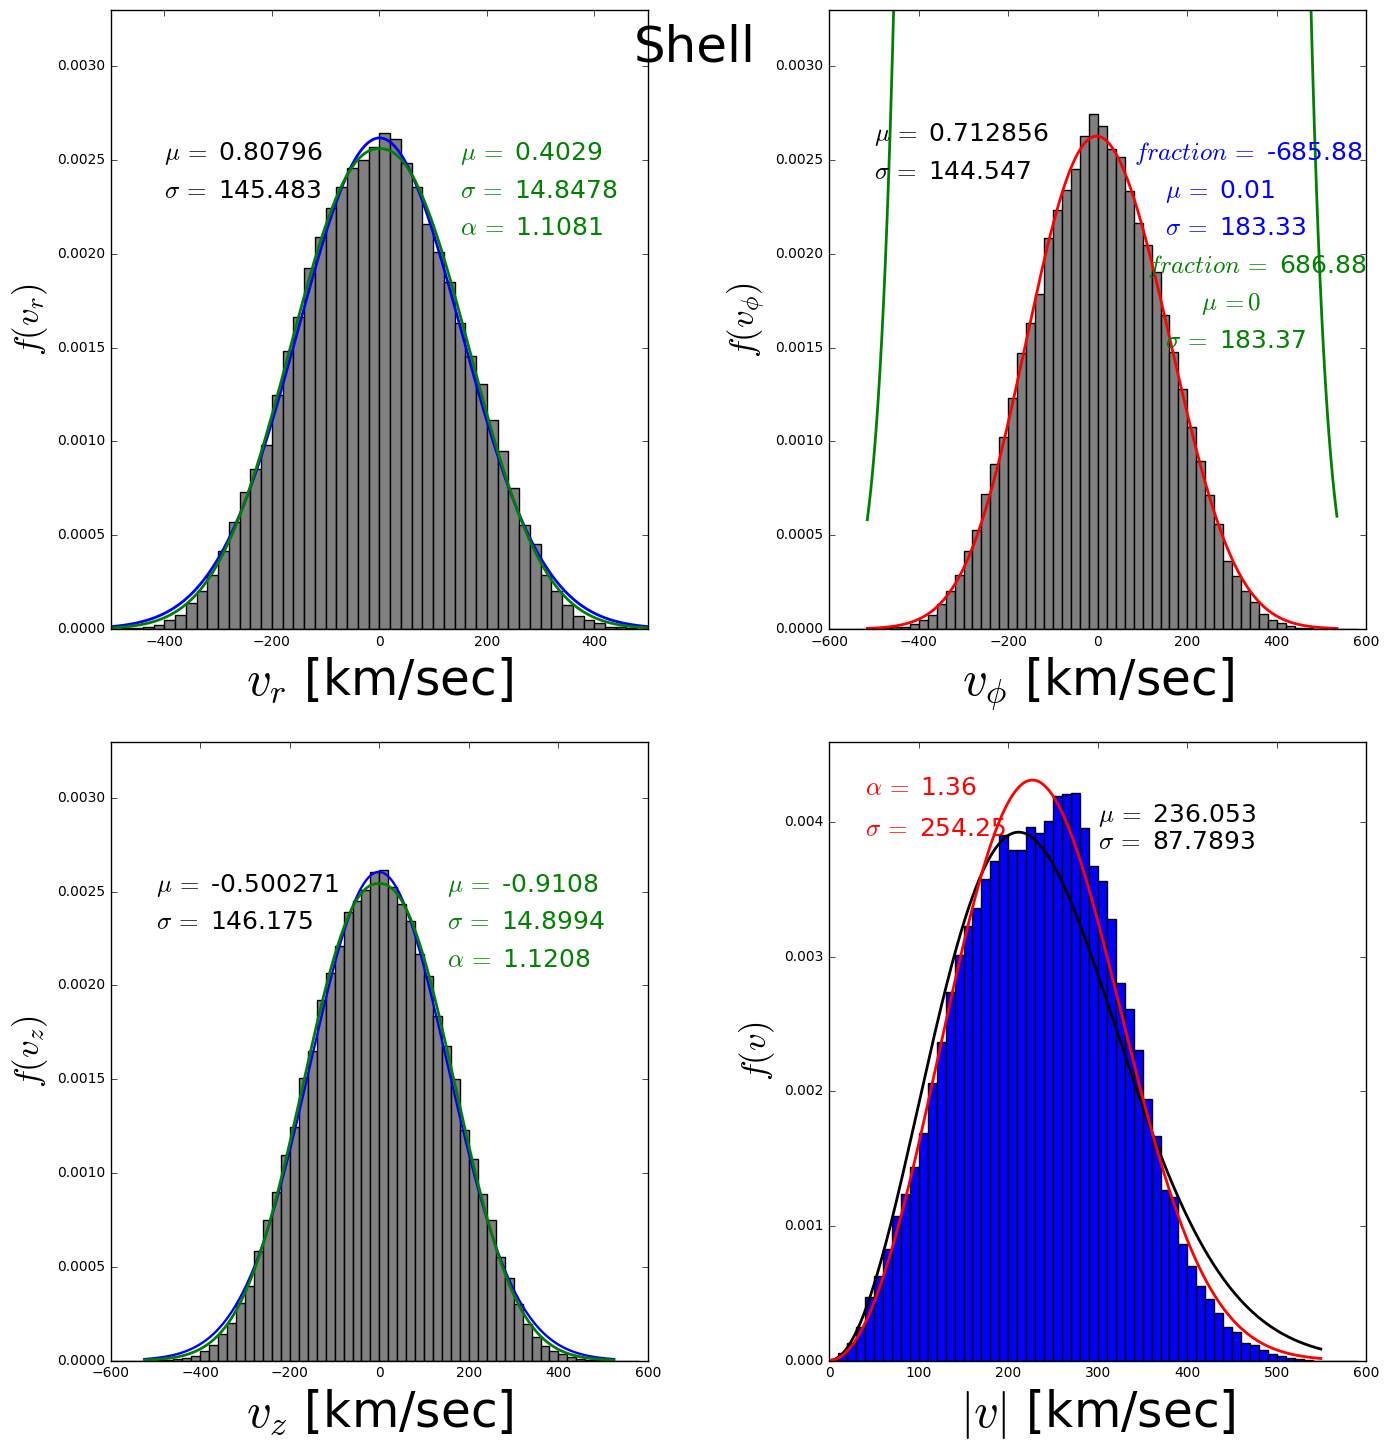

In [26]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
fig.tight_layout(w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("Shell", size=36)
ax.set_xlabel(r'$v_r$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_r)$',fontsize=25)
ax.set_xlim([-500,500])
ax3.set_xlim([0,600])
ax.set_ylim([0,33e-4])
ax1.set_ylim([0,33e-4])
ax2.set_ylim([0,33e-4])
ax3.set_ylim([0,46e-4])

bin_array = np.arange(-600,600,20)

ax.bar(vR_Hist_shell[1][:-1],vR_Hist_shell[0], width=20,
        color='gray')
ax.text(-400,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vR_shell)),size=18)
ax.text(-400,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vR_shell))),
        size=18)

#ax.plot(testx,myDoubleGaussianFunc(testx,popt[0],popt[1],popt[2],popt[3]))
ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)

fig.tight_layout(w_pad=5.5, h_pad=2.0)

ax1.bar(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0], width=20,
        color='gray')

ax1.text(-500,0.0026,r'$\mu\,=$ '+str(np.mean(dmHALO.vphi_shell)),size=18)
ax1.text(-500,0.0024,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vphi_shell))),
        size=18)
#fig, (ax,ax1) = plt.subplots(1,2,figsize=[13,6])
#plt.tight_layout(w_pad=5.5, h_pad=1.0)
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)


ax2.bar(vz_Hist_shell[1][:-1],vz_Hist_shell[0], width=20,
        color='gray')
ax2.text(-500,0.0025,r'$\mu\,=$ '+str(np.mean(dmHALO.vz_shell)),size=18)
ax2.text(-500,0.0023,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.vz_shell))),
        size=18)
bin_array2 = np.arange(0,600,10)

ax3.bar(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0], width=10,
        color='blue')
ax3.text(300,0.004,r'$\mu\,=$ '+str(np.mean(dmHALO.v_shell)),size=18)
ax3.text(300,0.0038,r'$\sigma\,=$ '+str(sqrt(np.var(dmHALO.v_shell))),
        size=18)



v_test = np.arange(-525,525)
ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

ax.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(R_GG_fit[0])),size=18,color="green")
ax.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(R_GG_fit[1]))),
        size=18,color="green")
ax.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(R_GG_fit[2])),
        size=18,color="green")


ax1.plot(v_test+10,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test+10, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
ax1.plot(v_test+10, myDoubleGaussianFunc(v_test,phi_DG_fit[0],
                                      phi_DG_fit[1],phi_DG_fit[2],
                                      phi_DG_fit[3]),linewidth = 2)

ax1.text(80,0.0025,r'$fraction\,=$ '+str('{0:.2f}'.format(phi_DG_fit[0])),
        size=18,color="blue")
ax1.text(150,0.0023,r'$\mu\,=$ '+str('{0:.2f}'.format((phi_DG_fit[2]))),
        size=18,color="blue")
ax1.text(150,0.0021,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[1])),
        size=18,color="blue")
ax1.text(110,0.0019,r'$fraction\,=$ '+str('{0:.2f}'.format(1-phi_DG_fit[0])),
        size=18,color="green")
ax1.text(230,0.0017,r'$\mu\,=0$ ',
        size=18,color="green")
ax1.text(150,0.0015,r'$\sigma\,=$ '+str('{0:.2f}'.format(phi_DG_fit[3])),
        size=18,color="green")


ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

ax2.text(150,0.0025,r'$\mu\,=$ '+str('{0:.4f}'.format(z_GG_fit[0])),size=18,color="green")
ax2.text(150,0.0023,r'$\sigma\,=$ '+str('{0:.4f}'.format(sqrt(z_GG_fit[1]))),
        size=18,color="green")
ax2.text(150,0.0021,r'$\alpha\,=$ '+str('{0:.4f}'.format(z_GG_fit[2])),
        size=18,color="green")

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)

ax3.text(40,0.0042,r'$\alpha\,=$ '+str('{0:.2f}'.format((v_GM_fit[1]))),
        size=18,color="red")
ax3.text(40,0.0039,r'$\sigma\,=$ '+str('{0:.2f}'.format(v_GM_fit[0])),
        size=18,color="red")

In [30]:
print len (dmHALO.vr_ringXY)
print len (dmHALO.vr_shell)

11593
86163
